# **Data Processing**


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import spacy
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from textblob import TextBlob

import chardet



In [67]:
def open_tsv_file(filename):
    rows = []
    with open(filename, 'r', encoding='utf-8') as file:
      for line in file:
          fields = line.strip().split('\t')
          # Check if the line contains more than three fields (indicating a combined line)
          if len(fields) > 3:
              match = re.match(r'(.*?)(Yes|No)(\d+)', fields[2])
              if match:
                  class_label = match.group(2)
                  next_sentence_id = match.group(3)
                  # Append two separate rows with corrected structure
                  rows.append([fields[0], fields[1], class_label])
                  rows.append([next_sentence_id, fields[3], fields[4]])
          else:
              rows.append(fields)
    return rows

try:
  train_df = pd.read_csv('CT24_checkworthy_english_train.tsv', sep='\t', header=None, names=['sentence_id', 'text', 'class_label'])
except pd.errors.ParserError:
  rows = open_tsv_file('CT24_checkworthy_english_train.tsv')
  train_df = pd.DataFrame(rows[1:], columns=['sentence_id', 'text', 'class_label'])


# Data exploration

*   Displaying 1st few rows.
*   Check for shape, missing values,and class distribution.
*   Explore the length of the text data to understand its distribution.
*   Detect outliners.
*   Identify and print 1st 20 most common words.  
*   Check for dublicates: tweets, texts or ids.
*   Visualization of Text Length Distribution and Class Distribution, and Sentiment Polarity.


Dataset shape: (22501, 3)

Missing values:
sentence_id    0
text           0
class_label    0
dtype: int64

Class distribution:
 class_label
No     0.759433
Yes    0.240567
Name: proportion, dtype: float64

Text length statistics:
 count    22501.000000
mean        17.943603
std         12.750019
min          1.000000
25%          9.000000
50%         14.000000
75%         23.000000
max        152.000000
Name: text_length, dtype: float64

Duplicate Sentence IDs: 0
Duplicate Texts: 98

Most Common Words:
 [('the', 19773), ('to', 14333), ('of', 9537), ('and', 9295), ('that', 8603), ('a', 8204), ('I', 7524), ('in', 7411), ('we', 5100), ('have', 4615), ('is', 4223), ('for', 3480), ('you', 3099), ('it', 2686), ('on', 2444), ('be', 2424), ('our', 2390), ('with', 2306), ('are', 2294), ('this', 2285)]


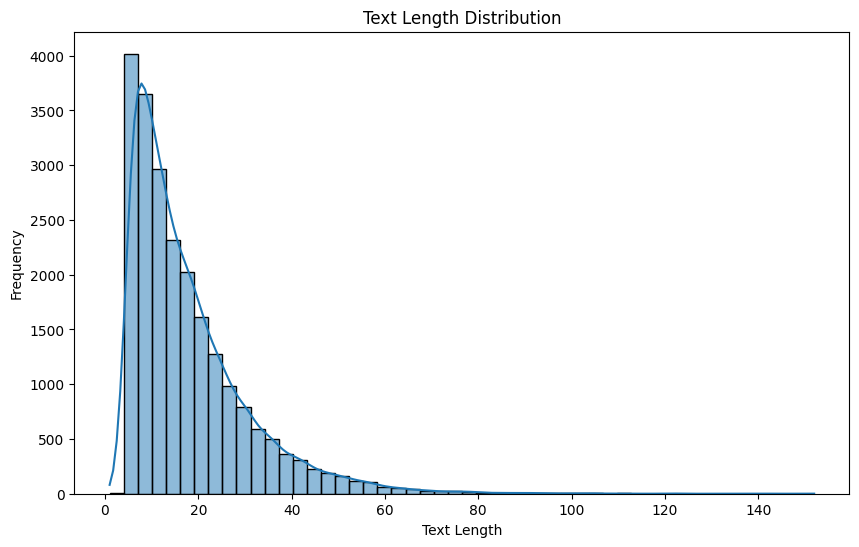

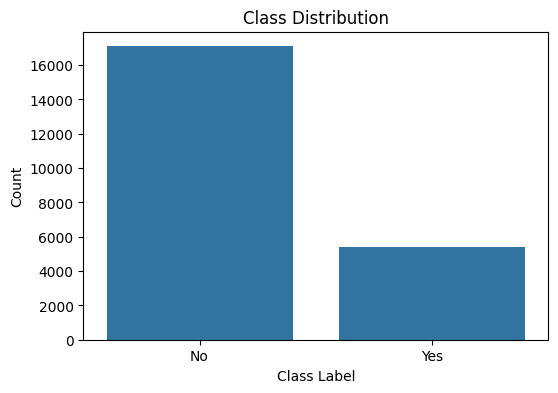

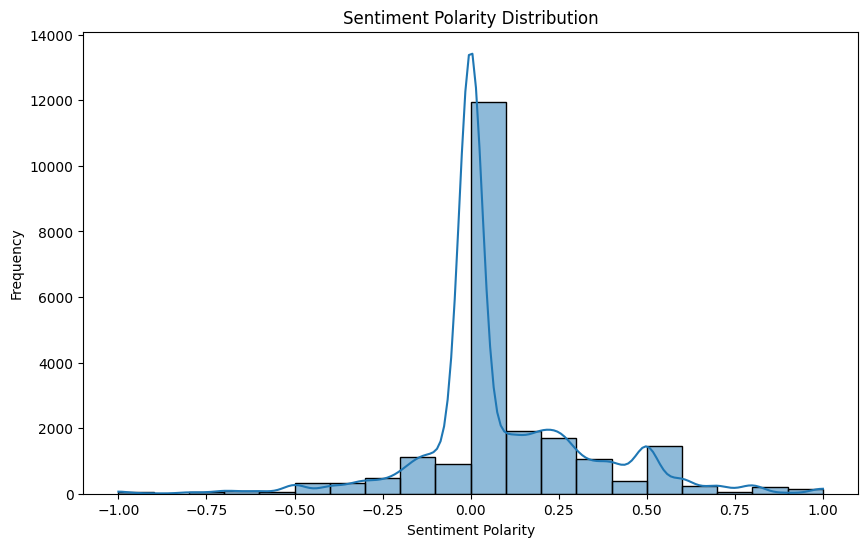


Text Length Outliers:
       sentence_id                                               text  \
12          32025  "But when you talk about apology, I think the ...   
24          21897  They concluded that my plan would cover everyb...   
29           1072  "But I do make a pledge that in the next ten d...   
31          14683  "I really can't believe Mr. Bush is still tryi...   
56            505  "Well, I must have been living through a diffe...   
...           ...                                                ...   
22435       23909  But he has made -- not admitted a mistake and ...   
22448         610  "I mean, there's plenty of them that I oppose,...   
22455        9042  "That it was placed here to be found by a spec...   
22475       17688  "How you can cut school lunches, how you can c...   
22495        3341  "One of the uh - most embarrassing uh - failur...   

       text_length  
12              60  
24              66  
29              58  
31              57  
56    

,sentence_id,text,class_label,text_length,sentiment
0,30313,And so I know that this campaign has caused so...,No,22,0.5
1,19099,"""Now, let's balance the budget and protect Med...",No,13,0.0
2,33964,I'd like to mention one thing.,No,6,0.0
3,16871,I must remind him the Democrats have controlle...,Yes,22,0.0
4,13150,"""And to take a chance uh - now be - and not ma...",No,34,0.8


In [68]:
def data_exploration(train_df):
    print(f"Dataset shape: {train_df.shape}")
    print(f"\nMissing values:\n{train_df.isnull().sum()}")
    print("\nClass distribution:\n", train_df['class_label'].value_counts(normalize=True))

    train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))
    print("\nText length statistics:\n", train_df['text_length'].describe())

    print("\nDuplicate Sentence IDs:", train_df.duplicated(subset='sentence_id').sum())
    print("Duplicate Texts:", train_df.duplicated(subset='text').sum())

    words = ' '.join(train_df['text']).split()
    word_freq = Counter(words)
    print("\nMost Common Words:\n", word_freq.most_common(20))

    plt.figure(figsize=(10, 6))
    sns.histplot(train_df['text_length'], bins=50, kde=True)
    plt.title('Text Length Distribution')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.countplot(data=train_df, x='class_label')
    plt.title('Class Distribution')
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.show()

    train_df['sentiment'] = train_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

    plt.figure(figsize=(10, 6))
    sns.histplot(train_df['sentiment'], bins=20, kde=True)
    plt.title('Sentiment Polarity Distribution')
    plt.xlabel('Sentiment Polarity')
    plt.ylabel('Frequency')
    plt.show()

    q1 = train_df['text_length'].quantile(0.25)
    q3 = train_df['text_length'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = train_df[(train_df['text_length'] < lower_bound) | (train_df['text_length'] > upper_bound)]
    print("\nText Length Outliers:\n", outliers[['sentence_id', 'text', 'text_length']])

    return

data_exploration(train_df)
train_df.head()

# **Essential preprocessing**
* Text Cleaning and Normalization: remove ambiguous phrases, handle spescial characters, remove double quotes/extra spaces/repeated words or phrases.
* Number normalization: converting to numerical format
* Non-ASCII Character Removal
* Special Annotations Removal
* Named Entities Extraction
* Duplicate Removal
* Sentiment Polarity Binning and Text Length Binning

In [69]:

nlp = spacy.load("en_core_web_sm")


def extract_named_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ['DATE', 'PERSON', 'ORG', 'GPE']]
    return entities

In [70]:
def remove_ambiguous_phrases(text):
    specific_phrases = ['Well', 'Listen', 'First of all','Look', 'Yeah', 'Uh', 'uh', 'yeah']
    for phrase in specific_phrases:
        text = re.sub(r'\b{}\b'.format(phrase), '', text, flags=re.IGNORECASE)
        if phrase.lower() != phrase:
          # Remove commas at the start of the text or after spaces and double quotes at the start
          text = re.sub(r'^,\s*', '', text)
          text = re.sub(r'^"\s*,\s*', '" ', text)
          # Remove extra spaces at the start after double quote
          text = re.sub(r'"(\s+)', '"', text)

          text = re.sub(r'(?<=^"|^\s)(\w+)', lambda x: x.group(1).capitalize(), text)

    text = re.sub(r',\s*well,', ',', text, flags=re.IGNORECASE)
    text = re.sub(r',\s*listen,', ',', text, flags=re.IGNORECASE)

    text = re.sub(r'\s+', ' ', text) # Remove extra space


    return text.strip()

def handle_special_characters(text):
    # Remove the '#' character
    text = re.sub(r'#', '', text)
    #text = re.sub(r'[-—]+', ' ', text)     # Handle hyphens and dashes
    text = re.sub(r'\\', '', text)  # Remove backslashes
    text = re.sub(r'"{2,}', '"', text) # Replace more than 1 double quote with single
    return text.strip()


def handle_annotations(text):
    text = re.sub(r'\[\w+\]', '', text)
    return text.strip()


def handle_non_ascii(text):
    # Detect encoding of the text
    encoding = chardet.detect(text.encode())['encoding']

    try:
        # Decode the text using detected encoding
        cleaned_text = text.encode(encoding).decode(encoding)
    except UnicodeDecodeError:
        # If decoding fails, replace invalid characters
        cleaned_text = ''.join(char if ord(char) < 128 else ' ' for char in text)

    # Remove invalid characters
    cleaned_text = remove_invalid_characters(cleaned_text)

    return cleaned_text.strip()

def remove_invalid_characters(text):
    invalid_characters = ['Ã', '¢', 'Â', 'â', '¥', '€', '°']
    for char in invalid_characters:
        text = text.replace(char, '')

    return text


def clean_up(text):
    # Remove more than 2 consecutive commas or space-separated commas
    text = re.sub(r'(,{2,}|\s*,\s*,\s*)', ', ', text)

    # Remove comma at the start of a sentence
    text = re.sub(r'^\s*,', '', text)

    return text.strip()


def normalize_numbers(text):
    # Remove commas in numbers like 13,000
    text = re.sub(r'(\d+),(\d+)', r'\1\2', text)

    # Convert $13 to 13 dollars
    text = re.sub(r'\$(\d+)', r'\1 dollars', text)

    return text


def remove_repeated_words(text):
    # Using regex to find and remove repeated words or phrases: comma, space and hyphens
    text = re.sub(r'(\b\w+\b)[\s,\-]+(\1\b)', r'\1', text)
    return text.strip()


def preprocessing(train_df):
    train_df = train_df.copy()

    # For merging purpose with other languages
    train_df['hashtags'] = train_df['text'].apply(lambda x: [])
    train_df['mentions'] = train_df['text'].apply(lambda x: [])


    # Text Cleaning and Normalization
    train_df['text'] = train_df['text'].apply(handle_annotations)
    train_df['text'] = train_df['text'].apply(handle_special_characters)
    train_df['text'] = train_df['text'].apply(remove_ambiguous_phrases)
    train_df['text'] = train_df['text'].apply(remove_repeated_words)
    train_df['text'] = train_df['text'].apply(handle_non_ascii)
    train_df['text'] = train_df['text'].apply(normalize_numbers)
    train_df['text'] = train_df['text'].apply(clean_up)

    #train_df['named_entities'] = train_df['text'].apply(lambda x: extract_named_entities(x))

    bins = [-1, -0.25, 0, 0.25, 0.5, 0.75, 1]
    labels = ['very_negative', 'negative', 'neutral', 'positive', 'very_positive', 'extremely_positive']
    train_df['sentiment_category'] = pd.cut(train_df['sentiment'], bins=bins, labels=labels)

    bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, np.inf]
    labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '100+']
    train_df['text_length_category'] = pd.cut(train_df['text_length'], bins=bins, labels=labels)

    label_encoder = LabelEncoder()
    train_df['class_label_encoded'] = label_encoder.fit_transform(train_df['class_label'])


    train_df = train_df.drop(columns=['text_length', 'sentiment'])


    return train_df

train_df = preprocessing(train_df)
train_df.head()


,sentence_id,text,class_label,hashtags,mentions,sentiment_category,text_length_category,class_label_encoded
0,30313,And so I know that this campaign has caused so...,No,[],[],positive,21-30,0
1,19099,"""Now, let's balance the budget and protect Med...",No,[],[],negative,11-20,0
2,33964,I'd like to mention one thing.,No,[],[],negative,0-10,0
3,16871,I must remind him the Democrats have controlle...,Yes,[],[],negative,21-30,1
4,13150,"""And to take a chance - now be - and not make ...",No,[],[],extremely_positive,31-40,0


# **Preprocessing for Evaluation**

For other files (dev.tsv and dev-test.tsv), since they contain only two columns (sentence_id and text).

*   Preprocess the dev_df and dev_test_df dataframes using the existing functions.
*   Save the processed data into separate TSV files (processed_dev.tsv and processed_dev_test.tsv) for evaluation.

In [71]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Function to count frequency of hashtags
def count_hashtags_frequency(text):
    hashtags = re.findall(r"#(\w+)", text)
    return len(hashtags)

# Function to analyze sentiment of hashtags
def analyze_hashtag_sentiment(text):
    hashtags = re.findall(r"#(\w+)", text)
    if hashtags:
        sentiment_scores = [TextBlob(hashtag).sentiment.polarity for hashtag in hashtags]
        avg_sentiment = sum(sentiment_scores) / len(sentiment_scores)
        return avg_sentiment
    else:
        return 0.0

# Function for topic modeling with LDA
def topic_modeling_with_lda(texts):
    if not texts or texts == ['']:
        return 0  # Return a placeholder value if texts is empty

    vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
    dtm = vectorizer.fit_transform(texts)

    lda = LatentDirichletAllocation(n_components=5, random_state=42)
    lda.fit(dtm)

    topics = lda.transform(dtm)

    return topics.argmax(axis=1)[0]  # Return just the integer value of the topic

def add_additional_features(train_df):
    # Count frequency of hashtags and mentions
    train_df['hashtags_frequency'] = train_df['text'].apply(count_hashtags_frequency)

    # Analyze sentiment of hashtags
    train_df['hashtags_sentiment'] = train_df['text'].apply(analyze_hashtag_sentiment)

    # Topic modeling with LDA for hashtags
    train_df['hashtags_topics'] = train_df['hashtags'].apply(lambda x: topic_modeling_with_lda([' '.join(x)]) if x else 0)

    return train_df

# Add additional features
train_df = add_additional_features(train_df)
train_df.head(4)


,sentence_id,text,class_label,hashtags,mentions,sentiment_category,text_length_category,class_label_encoded,hashtags_frequency,hashtags_sentiment,hashtags_topics
0,30313,And so I know that this campaign has caused so...,No,[],[],positive,21-30,0,0,0.0,0
1,19099,"""Now, let's balance the budget and protect Med...",No,[],[],negative,11-20,0,0,0.0,0
2,33964,I'd like to mention one thing.,No,[],[],negative,0-10,0,0,0.0,0
3,16871,I must remind him the Democrats have controlle...,Yes,[],[],negative,21-30,1,0,0.0,0


Dataset shape: (1032, 3)

Missing values:
sentence_id    0
text           0
class_label    0
dtype: int64

Class distribution:
 class_label
No     0.76938
Yes    0.23062
Name: proportion, dtype: float64

Text length statistics:
 count    1032.000000
mean       16.706395
std        12.148533
min         5.000000
25%         8.000000
50%        13.000000
75%        22.000000
max        98.000000
Name: text_length, dtype: float64

Duplicate Sentence IDs: 0
Duplicate Texts: 1

Most Common Words:
 [('the', 831), ('to', 635), ('of', 443), ('a', 372), ('that', 366), ('I', 365), ('and', 365), ('in', 356), ('we', 272), ('have', 203), ('is', 201), ('for', 173), ('are', 118), ('our', 118), ('it', 110), ('you', 105), ('on', 101), ('not', 101), ('be', 99), ('do', 98)]


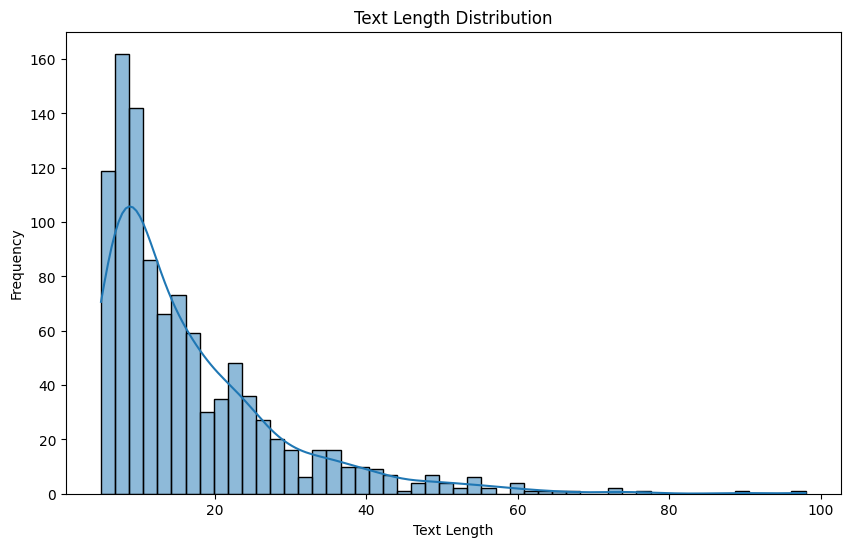

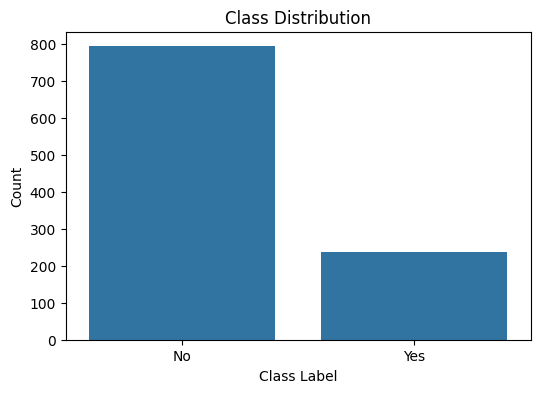

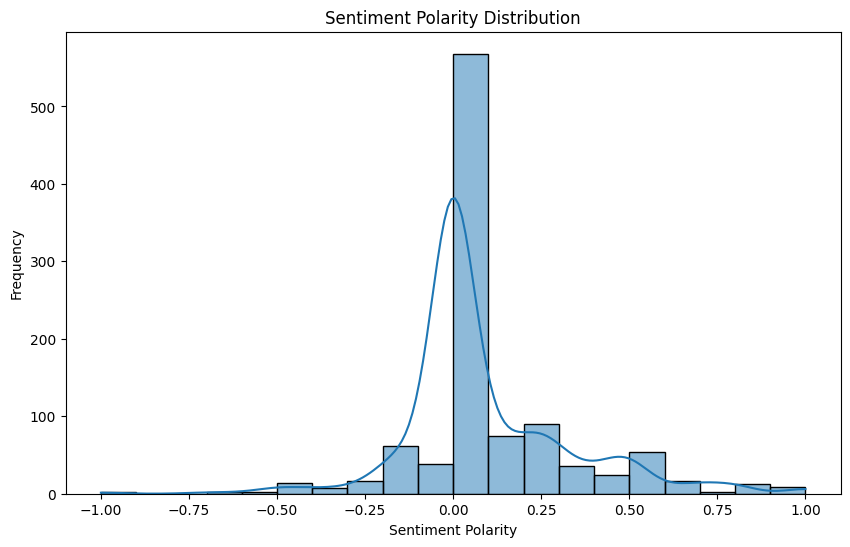


Text Length Outliers:
      sentence_id                                               text  \
7            228  I think we have to demonstrate some flexibilit...   
11           543  "The federal government spends seven percent o...   
21          1037  "We now have one extreme for instance, of some...   
27          1242  "A mayor of a city like New York, for instance...   
32          1342  "Uh - Mr. Maynard, uh - the record of gun cont...   
56          2148  "And using that money, we were actually able t...   
109         4390  "And I -- and I honestly don't believe that Se...   
124         5540  "Joe, I want to tell you, I'll not only help y...   
133         5571  "Why would you want to do that, anyone, anyone...   
142         5608  "Well, first of all, I think it's important fo...   
172         5784  "I think that, if you look at the record and t...   
277         6882  "But more importantly, with respect to the que...   
292         7074  "And so in order to take pressure o

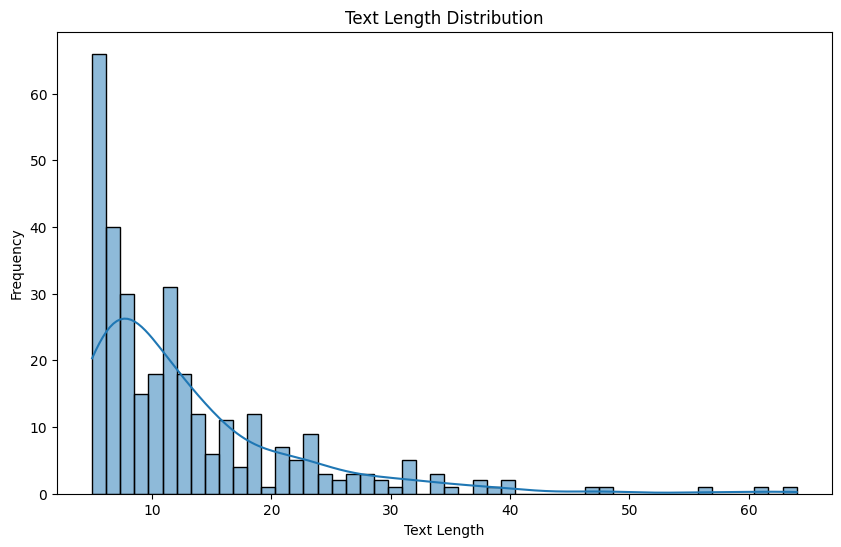

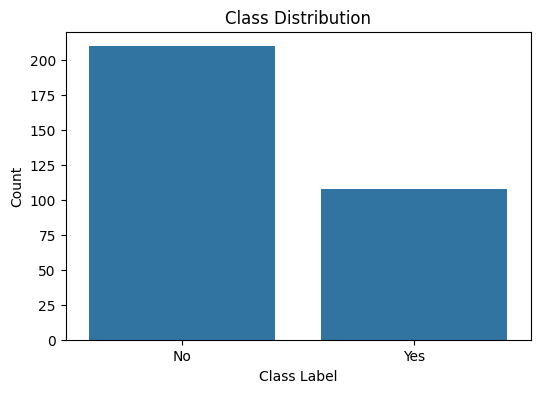

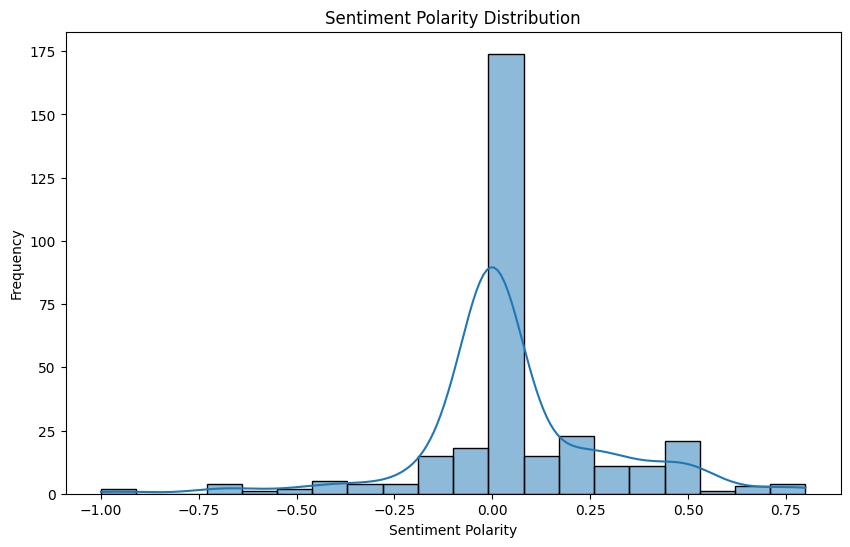


Text Length Outliers:
     sentence_id                                               text  \
45        37840  "How many of you are in a situation where you ...   
63        38144  "The fact is that he has in fact, worked on th...   
117       38882  "With regard to being weaker, the fact is that...   
167       39507  "Anyone who's responsible for not taking contr...   
175       39553  "When I closed and banned China from coming in...   
176       39560  "Look, his own person who ran that for him who...   
193       39747  "We have to open up and we understand the dise...   
194       39775  "But, guess what, in the meantime, we find out...   
211       39867  "We learn that this President paid 50 times th...   
231       40082  "So, when I met with Barack Obama, we sat in t...   
244       40212  "It's gotten endorsed by all the major labor u...   
245       40214  "And this is going to give some people an oppo...   
247       40245  "And they're going to have lower premiums, you...

In [72]:
import csv

def preprocess_dev_data(df):
    data_exploration(df)
    df = preprocessing(df)
    return add_additional_features(df)

def save_processed_dev_data(df, filepath):
    df.to_csv(filepath, sep='\t', index=False, quoting=csv.QUOTE_NONE)

# Load dev.tsv file
rows_dev = open_tsv_file('CT24_checkworthy_english_dev.tsv')
dev_df = pd.DataFrame(rows_dev[1:], columns=['sentence_id', 'text', 'class_label'])
# Preprocessing dev_df
processed_dev_data = preprocess_dev_data(dev_df)

# Load dev-test.tsv file
rows_dev_test_df = open_tsv_file('CT24_checkworthy_english_dev-test.tsv')
dev_test_df = pd.DataFrame(rows_dev_test_df[1:], columns=['sentence_id', 'text', 'class_label'])
# Preprocessing dev_test_df
processed_dev_test_data = preprocess_dev_data(dev_test_df)

save_processed_dev_data(train_df, 'processed_train.tsv')
save_processed_dev_data(processed_dev_data, 'processed_dev.tsv')
save_processed_dev_data(processed_dev_test_data, 'processed_dev_test.tsv')

# **Tokenization for XML-RoBERTa-Large**

In [73]:
from transformers import XLMRobertaTokenizer

# Initialize the XLM-RoBERTa tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

def tokenize_text(text):
    tokenized_text = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
    return tokenized_text

# Tokenization for XLM-RoBERTa-Large
train_tokenized = train_df['text'].apply(tokenize_text)
dev_tokenized = dev_df['text'].apply(tokenize_text)
dev_test_tokenized = dev_test_df['text'].apply(tokenize_text)

In [74]:
import json

def convert_to_lists(tokenized_text):
    return {key: value.tolist() for key, value in tokenized_text.items()}

# Convert tokenized data to lists
train_tokenized_lists = train_tokenized.apply(convert_to_lists)
dev_tokenized_lists = dev_tokenized.apply(convert_to_lists)
dev_test_tokenized_lists = dev_test_tokenized.apply(convert_to_lists)

# Save tokenized data to JSON files
train_tokenized_lists.to_json("train_tokenized.json", orient="records", lines=True)
dev_tokenized_lists.to_json("dev_tokenized.json", orient="records", lines=True)
dev_test_tokenized_lists.to_json("dev_test_tokenized.json", orient="records", lines=True)